In [1]:
import pandas as pd
import numpy as np
import os
import PIL.Image as Image
from IPython.display import display

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
### Load the training array, labels and features
train_array = np.load('train_array.npy')
train_labels = np.load('train_labels.npy')
train_features = np.load('train_features.npy')

In [3]:
### Create directories for train, valid and test images
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'swissroads/train/')
valid_dir = os.path.join(base_dir, 'swissroads/valid/')
test_dir = os.path.join(base_dir, 'swissroads/test/')
### Create a list of categories/labels
categories = os.listdir(train_dir)
categories

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

In [4]:
img = Image.open('swissroads/train/bike/bike-0001.png')
IMG_SHAPE = img.size

In [5]:
BATCH_SIZE = 32

train_valid_generator = ImageDataGenerator(rescale=1/255, 
                                           rotation_range=10, 
                                           width_shift_range=0.2,
                                           height_shift_range=0.2, 
                                           zoom_range=0.2, 
                                           horizontal_flip=True,
                                           vertical_flip=True)

test_generator = ImageDataGenerator(rescale=1/255)

train_datagen = train_valid_generator.flow_from_directory(train_dir, 
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

valid_datagen = train_valid_generator.flow_from_directory(valid_dir, 
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE//2,
                                                          shuffle=False)

test_datagen = test_generator.flow_from_directory(test_dir, 
                                                  target_size=IMG_SHAPE,
                                                  batch_size=BATCH_SIZE//4,
                                                  shuffle=False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


# Convolutional Neural Network
You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?
- What accuracy can you achieve?
- Can you get good results? - If not, why?

In [6]:
### Define callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Build the model
def build_model():
    
    input_layer = tf.keras.Input(shape=IMG_SHAPE+(3, ))
    x = tf.keras.layers.Conv2D(64, 5, 3, padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(32, 5, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(input_layer, output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())

    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 86, 86, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0     

In [7]:
history = model.fit(train_datagen,
                    epochs=50,
                    callbacks=stop_early,
                    validation_data=valid_datagen)

Epoch 1/50
9/9 [==============================] - 5s 579ms/step - loss: 1.8046 - categorical_accuracy: 0.1393 - val_loss: 1.7822 - val_categorical_accuracy: 0.1655
Epoch 2/50
9/9 [==============================] - 5s 538ms/step - loss: 1.7676 - categorical_accuracy: 0.1929 - val_loss: 1.7579 - val_categorical_accuracy: 0.2302
Epoch 3/50
9/9 [==============================] - 5s 535ms/step - loss: 1.7476 - categorical_accuracy: 0.2536 - val_loss: 1.7509 - val_categorical_accuracy: 0.2374
Epoch 4/50
9/9 [==============================] - 5s 562ms/step - loss: 1.7543 - categorical_accuracy: 0.2393 - val_loss: 1.7466 - val_categorical_accuracy: 0.2158
Epoch 5/50
9/9 [==============================] - 5s 532ms/step - loss: 1.7476 - categorical_accuracy: 0.2571 - val_loss: 1.7510 - val_categorical_accuracy: 0.2302
Epoch 6/50
9/9 [==============================] - 5s 537ms/step - loss: 1.7501 - categorical_accuracy: 0.2464 - val_loss: 1.7370 - val_categorical_accuracy: 0.2518
Epoch 7/50
9/9 [

In [8]:
loss, accuracy = model.evaluate(valid_datagen)
print('Loss: {:.2f}'.format(loss))
print('Accuracy: {:.2f}'.format(accuracy))

9/9 [==============================] - 2s 164ms/step - loss: 1.4358 - categorical_accuracy: 0.4245
Loss: 1.44
Accuracy: 0.42


It is possible to achieve a validation accuracy of 51%, that is much lower than the previous models.  
This because we are training our model on the images with many parameters and not on the features, that have been already pre-trained.  

In [9]:
loss, accuracy = model.evaluate(test_datagen)
print('Loss: {:.2f}'.format(loss))
print('Accuracy: {:.2f}'.format(accuracy))

7/7 [==============================] - 0s 27ms/step - loss: 1.4409 - categorical_accuracy: 0.4000
Loss: 1.44
Accuracy: 0.40


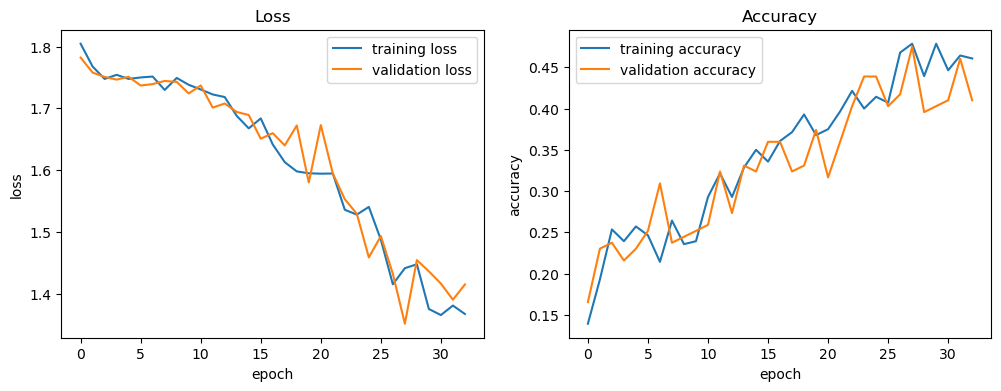

In [10]:
### Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], label='training accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy') # last three values
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()